<a href="https://colab.research.google.com/github/Shaunak-Mukherjee/ControlNet-ECE570/blob/main/Main_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
Below is implementation of ControlNet in PyTorch for [denoising diffusion probabilistic models](https://arxiv.org/abs/2006.11239) used on MNIST dataset

*  Training and Inference of DDPM on MNIST dataset
*  Training and Inference of ControlNet with DDPM on MNIST using canny edges

Current reimplementaton is adopted from the original codebase are found in below repositories-
https://github.com/lllyasviel/ControlNet, https://github.com/explainingai-code/VAE-Pytorch#data-preparation, https://github.com/explainingai-code/ControlNet-PyTorch



# Setting up evironment to run Controlnet on Google Colab

In [2]:
import subprocess
import pkg_resources

def check_and_install_requirements(requirements_file):
    """
    Checks if all packages listed in a requirements file are installed with the correct versions.
    If any packages are missing or have version mismatches, attempts to install the correct versions.

    Parameters:
        requirements_file (str): Path to the requirements.txt file.

    Returns:
        list: A list of (package, required_version) tuples for unmet requirements.
    """
    unmet_requirements = []

    # Version mismatches or missing packages
    with open(requirements_file, 'r') as file:
        for line in file:
            if '==' in line:
                package, required_version = line.strip().split('==')
                try:
                    installed_version = pkg_resources.get_distribution(package).version
                    if installed_version != required_version:
                        print(f"{package} version mismatch: required {required_version}, found {installed_version}")
                        unmet_requirements.append((package, required_version))
                except pkg_resources.DistributionNotFound:
                    print(f"{package} not installed.")
                    unmet_requirements.append((package, required_version))

    # If there are unmet requirements, install them
    if unmet_requirements:
        print(f"Requirements not met. Installing missing or mismatched packages from {requirements_file}.")
        try:
            subprocess.check_call(['pip', 'install', '-r', requirements_file])
            print("Installation of required packages completed.")
        except subprocess.CalledProcessError as e:
            print(f"Error occurred during installation: {e}")
    else:
        print("All requirements are already met; no installation needed.")

    return unmet_requirements

if __name__ == "__main__":
    requirements_file = '/content/drive/MyDrive/ControlNet-ECE570/requirements.txt'
    unmet_requirements = check_and_install_requirements(requirements_file)


certifi version mismatch: required 2024.8.30, found 2023.11.17
cffi version mismatch: required 1.17.1, found 1.16.0
charset-normalizer version mismatch: required 3.4.0, found 3.3.2
distro version mismatch: required 1.9.0, found 1.8.0
idna version mismatch: required 3.10, found 3.6
jsonpointer version mismatch: required 3.0.0, found 2.4
nvidia-cublas-cu12 version mismatch: required 12.6.3.3, found 12.4.5.8
nvidia-cuda-cupti-cu12 version mismatch: required 12.6.80, found 12.4.127
nvidia-cuda-runtime-cu12 version mismatch: required 12.6.77, found 12.4.127
nvidia-cudnn-cu12 version mismatch: required 9.5.1.17, found 9.1.0.70
nvidia-cufft-cu12 version mismatch: required 11.3.0.4, found 11.2.1.3
nvidia-curand-cu12 version mismatch: required 10.3.7.77, found 10.3.5.147
nvidia-cusolver-cu12 version mismatch: required 11.7.1.2, found 11.6.1.9
nvidia-cusparse-cu12 version mismatch: required 12.5.4.2, found 12.3.1.170
nvidia-nccl-cu12 version mismatch: required 2.23.4, found 2.21.5
nvidia-nvjitli

In [3]:
%pip install condacolab
import condacolab
condacolab.install()
%cd /content/drive/MyDrive/ControlNet-ECE570

✨🍰✨ Everything looks OK!
/content/drive/MyDrive/ControlNet-ECE570


Install required packages. Move to GPU for final run. Note depending on use of GPU vs CPU package versions will differ.

In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Sat Nov  9 02:09:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              44W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

Import required packages

In [5]:
# Import all necessary packages.
# Re-run these once runtime (CPU-> GPU) is switched.
import os
import glob
import yaml
import cv2
import numpy as np
import csv
from tqdm import tqdm
import glob
from tabulate import tabulate
import torch
import torchvision
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from PIL import Image
import argparse
from torchvision.utils import make_grid
from torch.optim import Adam
from torch.utils.data import Dataset
import random

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Extract MNIST Dataset

# Data source

 Originally from https://yann.lecun.com/exdb/mnist/. The csv files of the dataset imported using instructions found at Kaggle. https://www.kaggle.com/datasets/oddrationale/mnist-in-csv. The dataset consists of two csv files stored under project directory:

    ControlNet-ECE570\data\mnist_train.csv
    ControlNet-ECE570\data\mnist_test.csv
    
The `mnist_train.csv` file includes 60,000 training samples along with their corresponding labels, while the `mnist_test.csv` file contains 10,000 test samples and labels. Each row in these files consists of 785 values: the first value represents the label (a digit between 0 and 9), and the remaining 784 values represent the pixel intensity values (ranging from 0 to 255).

The extracted png image files were saved under



'/content/drive/MyDrive/ControlNet-ECE570/data/mnist/train/images'
'/content/drive/MyDrive/ControlNet-ECE570/data/mnist/test/images'




 Below code, extracts and saves images from the CSV files containing the MNIST dataset. It iterates over each row, reshapes the image data, and saves it as a PNG file in a directory corresponding to its label. If images already exists it will skip to the next code block.


In [6]:
def extract_images(save_dir, csv_filename, trigger=False, expected_count= None):
    """
    Function to extract and save images from a CSV file for the MNIST dataset.
    Includes a check to ensure the correct number of images are extracted.

    Parameters:
    save_dir (str): The directory where images will be saved.
    csv_filename (str): The CSV file containing the MNIST data.
    trigger (bool): If True, overwrite existing images. For colab long
    download time if True.
    expected_count (int): Expected number of images for verification.
    """
    # Check if the save directory and CSV file exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    assert os.path.exists(csv_filename), f"'{csv_filename}' does not exist"

    # Check if images already exist in the save directory and skip if trigger=False
    if not trigger and len(glob.glob(os.path.join(save_dir, '**', '*.png'), recursive=True)) > 0:
        print(f"The images already exist in '{save_dir}', so skipping extraction.")
        return 0

    # Open the CSV file and count rows
    with open(csv_filename, 'r') as f:
        reader = csv.reader(f)
        rows = list(reader)
        actual_count = len(rows) - 1

        if expected_count is not None and actual_count != expected_count:
            raise ValueError(f"Expected {expected_count} images, but found {actual_count} rows in the CSV file.")
        rows = rows[1:]  # Skip the header row
        image_count = 0

        # Iterate over each row in the CSV file
        for idx, row in enumerate(tqdm(rows, desc=f"Extracting {csv_filename}")):
            im = np.zeros((784), dtype=np.uint8)
            im[:] = list(map(int, row[1:]))
            im = im.reshape((28, 28))
            label_dir = os.path.join(save_dir, row[0])
            if not os.path.exists(label_dir):
                os.makedirs(label_dir)

            # Save the image as a PNG file
            image_path = os.path.join(label_dir, f'{idx}.png')
            cv2.imwrite(image_path, im)
            image_count += 1
            if idx % 1000 == 0:
                print(f'Finished creating {idx+1} images in {save_dir}')

    print(f'Total images extracted and saved in {save_dir}: {image_count}')
    return image_count

def count_images_in_directory(directory):
    """Counts the number of PNG images in a directory and its subdirectories."""
    image_paths = glob.glob(os.path.join(directory, '**', '*.png'), recursive=True)
    return len(image_paths)

if __name__ == "__main__":

    # Extract images for the training set, with verification and count output
    train_count = extract_images(
        '/content/drive/MyDrive/ControlNet-ECE570/data/mnist/train/images',
        '/content/drive/MyDrive/ControlNet-ECE570/data/mnist_train.csv',
        expected_count=60000
    )

    # Extract images for the test set, with verification and count output
    test_count = extract_images(
        '/content/drive/MyDrive/ControlNet-ECE570/data/mnist/test/images',
        '/content/drive/MyDrive/ControlNet-ECE570/data/mnist_test.csv',
        expected_count=10000
    )

    # Count the images in the train and test directories
    actual_train_count = count_images_in_directory('/content/drive/MyDrive/ControlNet-ECE570/data/mnist/train/images')
    actual_test_count = count_images_in_directory('/content/drive/MyDrive/ControlNet-ECE570/data/mnist/test/images')

    # Print out the total counts for train and test sets
    print(f"Actual training images in folder: {actual_train_count}")
    print(f"Actual test images in folder: {actual_test_count}")

The images already exist in '/content/drive/MyDrive/ControlNet-ECE570/data/mnist/train/images', so skipping extraction.
The images already exist in '/content/drive/MyDrive/ControlNet-ECE570/data/mnist/test/images', so skipping extraction.
Actual training images in folder: 60000
Actual test images in folder: 10000


# Define YAML Configuration file

YAML is a human-readable data serialization language that is often used for writing configuration files. Information on the architechture of the models used here (DDPM-Denoising Diffusion Probabilistic Models and ControlNet) is included in addition to dataset parameters, path, sizes, and details of all model training parameters.

In [7]:
with open('/content/drive/MyDrive/ControlNet-ECE570/config/mnist.yaml', 'r') as file:
  mnist_yaml = yaml.safe_load(file)

# Create a list of tuples to represent the table data
table_data = []
for key, value in mnist_yaml.items():
  table_data.append([key, value])

# Print the table
print(tabulate(table_data, headers=['Parameter', 'Value'], tablefmt='fancy_grid'))

╒══════════════════╤═════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│ Parameter        │ Value                                                                                                                                                                                                                                                               │
╞══════════════════╪═════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╡
│ dataset_params   │ {'im_path': 'data/mnist/train/images', 'im_test_path': 'data/mnist/test/images', 'canny_im_size': 28}                             

This code defines a custom dataset class for MNIST images. It loads images, resizes them, and optionally returns edge-detected versions for the case of ControlNet. We will use canny egge images for inference once models are trained.

In [8]:
class MnistDataset(Dataset):

    """
    Class for loading and handling the MNIST dataset.
    """

    def __init__(self,split,im_path,im_ext='png',im_size=28,return_hints=False):

        """
        Args:
            split (str): Indicates 'train' or 'test' split for loading images.
            im_path (str): The root folder where images are stored.
            im_ext (str): Image file extension (e.g., 'png'). Default is 'png'.
            im_size (int): Size to which images are resized (default is 28 for MNIST).
            return_hints (bool): If True, returns canny edge-detected images as hints.
        """
        self.split = split
        self.im_ext = im_ext
        self.return_hints = return_hints
        self.images = self.load_images(im_path)

    def load_images(self, im_path):
        """
        Load all images from the specified directory and store their file paths.

        Args:
            im_path (str): Root path containing image folders.

        Returns:
            list: A list of all image file paths in the dataset.
        """
        assert os.path.exists(im_path), f"Image path {im_path} does not exist."

        ims = []  # List to store all image paths

        for dir_name in tqdm(os.listdir(im_path)):
            for filename in glob.glob(os.path.join(im_path, dir_name, f'*.{self.im_ext}')):
                ims.append(filename)


        print(f'Found {len(ims)} images for split "{self.split}"')
        return ims

    def __len__(self):
        """Return the total number of images in the dataset."""
        return len(self.images)

    def __getitem__(self, index):
        """
        Load an image and return it as a tensor.

        Args:
            index (int): Index of the image to load.

        Returns:
            torch.Tensor: The image tensor scaled to [-1, 1].

        """
        # Load image
        im = Image.open(self.images[index])

        # Convert the image to a tensor with values in the range [0, 1]
        image_tensor = torchvision.transforms.ToTensor()(im)

        # Scale tensor values to the range [-1, 1]
        image_tensor = (2 * image_tensor) - 1

        # If return_hints is True for case of ControlNet we will use later,
        # we add an edge-detected image as an extra feature

        if self.return_hints:
            # Load the image for edge detection
            canny_image = Image.open(self.images[index])
            canny_image = np.array(canny_image)

            # Apply Canny edge detection and convert images
            canny_image = cv2.Canny(canny_image, 100, 200)
            canny_image = canny_image[:, :, None]
            canny_image = np.concatenate([canny_image] * 3, axis=2)

            # Convert edge-detected image to a tensor
            canny_image_tensor = torchvision.transforms.ToTensor()(canny_image)

            # Return both the original image tensor and the edge-detected hint
            return image_tensor, canny_image_tensor
        else:
            # Return only the original image tensor
            return image_tensor

Linear Noise Scheduler specifically for Diffusion Model. It controls the amount of noise added to data at each step of the diffusion process.
$$q(x_t \mid x_{t-1}) = \mathcal{N}(x_t; \sqrt{1 - \beta_t} \, x_{t-1}, \, \beta_t I)$$
$$q(x_t \mid x_0) = \mathcal{N}(x_t; \sqrt{\bar{\alpha}_t} \, x_0, \, (1 - \bar{\alpha}_t) I)$$
$$\bar{\alpha}_t = \prod_{i=1}^t (1 - \beta_i)$$
and undergo reparameterization trick
Good vizualization is here https://erdem.pl/2023/11/step-by-step-visual-introduction-to-diffusion-models#diffusion-model-architecture (key idea https://arxiv.org/abs/1503.03585 and https://arxiv.org/abs/2006.11239). Beta start and end chosen as 0.0001 to 0.02 repectively from the reference.


In [9]:
class LinearNoiseScheduler:
    """
    Linear Noise Scheduler for Diffusion Model. Responsible for generating noise
    and controlling it at different steps.
    "The essential idea, inspired by non-equilibrium statistical physics, is to systematically and slowly destroy
    structure in a data distribution through an iterative forward diffusion process. We then learn a reverse diffusion
    process that restores structure in data, yielding a highly flexible and tractable generative model of the data."
    """
    def __init__(self, num_timesteps, beta_start, beta_end, ldm_scheduler= False):
        """
        Initialize the scheduler with noise settings.

        Args:
            num_timesteps (int): Total steps in the diffusion process.
            beta_start (float): Starting beta value (lower means less noise).
            beta_end (float): Ending beta value (higher means more noise).
            ldm_scheduler (bool): If True, adjust the noise schedule based on latent diffusion models (LDM).
        """
        self.num_timesteps = num_timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end


        if ldm_scheduler:
            self.betas = (torch.linspace(beta_start ** 0.5, beta_end ** 0.5, num_timesteps) ** 2)
        else:
            self.betas = torch.linspace(beta_start, beta_end, num_timesteps)

        # Calculate alpha values
        self.alphas = 1. - self.betas
        self.alpha_cum_prod = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_cum_prod = torch.sqrt(self.alpha_cum_prod)
        self.sqrt_one_minus_alpha_cum_prod = torch.sqrt(1 - self.alpha_cum_prod)

    def add_noise(self, original, noise, t):
        """
        Adds noise to the original data based on the timestep.

        Args:
            original (torch.Tensor): The original image or data.
            noise (torch.Tensor): Random noise tensor, sampled from a normal distribution.
            t (torch.Tensor): Timestep tensor indicating which step in the diffusion process.

        Returns:
            torch.Tensor: Noisy data combined based on the timestep.
        """
        original_shape = original.shape
        batch_size = original_shape[0]

        # Retrieve scaling factors
        sqrt_alpha_cum_prod = self.sqrt_alpha_cum_prod.to(original.device)[t].reshape(batch_size)
        sqrt_one_minus_alpha_cum_prod = self.sqrt_one_minus_alpha_cum_prod.to(original.device)[t].reshape(batch_size)

        # Adjust dimensions (Batch, Channel, Height, Width)
        for _ in range(len(original_shape) - 1):
            sqrt_alpha_cum_prod = sqrt_alpha_cum_prod.unsqueeze(-1)
            sqrt_one_minus_alpha_cum_prod = sqrt_one_minus_alpha_cum_prod.unsqueeze(-1)

        # Combine the original data and noise based on the forward diffusion equation
        # applies to forward diffusion xt​=αt​​⋅x0​ + (1−αt)​​⋅ϵ,
        return (sqrt_alpha_cum_prod * original) + (sqrt_one_minus_alpha_cum_prod * noise)

    def sample_prev_timestep(self, x_t, noise_predicton, t):
        """
        Sample the previous timestep value based on model's noise prediction.

        Args:
            x_t (torch.Tensor): The current noisy sample.
            noise_predicton (torch.Tensor): Predicted noise from the model.
            t (torch.Tensor): Current timestep.

        Returns:
            tuple: (Previous timestep sample, estimated original data)
        """
        # Estimate the original data
        x_0 = ((x_t - (self.sqrt_one_minus_alpha_cum_prod.to(x_t.device)[t] * noise_predicton)) /
              torch.sqrt(self.alpha_cum_prod.to(x_t.device)[t]))
        x_0 = torch.clamp(x_0, -1., 1.)

        # Calculate the mean
        mean = x_t - ((self.betas.to(x_t.device)[t]) * noise_predicton) / (self.sqrt_one_minus_alpha_cum_prod.to(x_t.device)[t])
        mean = mean / torch.sqrt(self.alphas.to(x_t.device)[t])

        # If at the first timestep, simply return the mean without extra noise
        if t == 0:
            return mean, x_0
        else:
            # Calculate variance for the Gaussian noise to add in reverse process
            variance = (1 - self.alpha_cum_prod.to(x_t.device)[t - 1]) / (1 - self.alpha_cum_prod.to(x_t.device)[t])
            variance *= self.betas.to(x_t.device)[t]
            sigma = variance ** 0.5
            # Sample noise for this step
            z = torch.randn(x_t.shape).to(x_t.device)

            # Return previous timestep sample by adding noise, along with estimated x_0
            return mean + sigma * z, x_0

According to Nichol and Dhariwal (2021) https://arxiv.org/abs/2102.09672 , a linear schedule is not well suited for low resolution images for example Mnist dataset that we plan to train here. So we will also look at cosine beta schedular originally developed by OpenAI.

## Define the DPPM Model




This model implements a variant of the UNet architecture that processes image data with the added capability of handling time-dependent features via sinusoidal time embeddings. The network includes multiple downsampling, mid-level, and upsampling blocks, each containing ResNet-style layers and attention mechanisms to ensure efficient feature learning and focus.

In [10]:
def get_time_embedding(time_steps, t_emb_dim):
    """
    Convert time steps tensor into an embedding using the
    sinusoidal time embedding formula.
    Args:
        time_steps (torch.Tensor): 1D tensor of length batch size.
        temb_dim (int): Dimension of the embedding.
    Returns:
        t_emb_dim - torch.Tensor: BxD embedding representation of B time steps.
    """
    assert t_emb_dim % 2 == 0, "time embedding dimension must be divisible by 2"
    factor = 10000 ** (torch.arange(0, t_emb_dim // 2, dtype=torch.float32, device=time_steps.device) / (t_emb_dim // 2))
    t_emb = time_steps[:, None].repeat(1, t_emb_dim // 2) / factor
    t_emb = torch.cat([torch.sin(t_emb), torch.cos(t_emb)], dim=-1)
    return t_emb


class DownBlock(nn.Module):
    """
    Down conv block with attention.
    Args:
      in_channels (int): Number of input channels.
      out_channels (int): Number of output channels.
      t_emb_dim (int): Dimension of the time embedding.
      down_sample (bool): Flag for downsampling.
      num_heads (int): Number of attention heads.
      num_layers (int): Number of layers.
      Consists of:
      1. Resnet block with time embedding.
      2. Attention block.
      3. Downsample using 2x2 average pooling.
    Returns:
      out (torch.Tensor): Output tensor after processing.
    """
    def __init__(self, in_channels, out_channels, t_emb_dim, down_sample=True, num_heads=4, num_layers=1):
        super().__init__()
        self.num_layers = num_layers
        self.down_sample = down_sample

        # Define ResNet layers
        self.resnet_conv_first = nn.ModuleList([
            nn.Sequential(
                nn.GroupNorm(8, in_channels if i == 0 else out_channels),
                nn.SiLU(),
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=3, stride=1, padding=1)
            ) for i in range(num_layers)
        ])
        self.t_emb_layers = nn.ModuleList([
            nn.Sequential(nn.SiLU(), nn.Linear(t_emb_dim, out_channels)) for _ in range(num_layers)
        ])
        self.resnet_conv_second = nn.ModuleList([
            nn.Sequential(
                nn.GroupNorm(8, out_channels),
                nn.SiLU(),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
            ) for _ in range(num_layers)
        ])

        # Define Attention layers
        self.attention_norms = nn.ModuleList([nn.GroupNorm(8, out_channels) for _ in range(num_layers)])
        self.attentions = nn.ModuleList([nn.MultiheadAttention(out_channels, num_heads, batch_first=True) for _ in range(num_layers)])
        self.residual_input_conv = nn.ModuleList([
            nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1) for i in range(num_layers)
        ])
        self.down_sample_conv = nn.Conv2d(out_channels, out_channels, 4, 2, 1) if self.down_sample else nn.Identity()

    def forward(self, x, t_emb):
        out = x
        for i in range(self.num_layers):
            # Resnet block
            resnet_input = out
            out = self.resnet_conv_first[i](out) + self.t_emb_layers[i](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i](out) + self.residual_input_conv[i](resnet_input)

            # Attention block
            batch_size, channels, h, w = out.shape
            in_attn = self.attention_norms[i](out.reshape(batch_size, channels, h * w)).transpose(1, 2)
            out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
            out = out + out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)

        out = self.down_sample_conv(out)
        return out


class MidBlock(nn.Module):
    """
    Mid conv block with attention.
    Args:
      in_channels (int): Number of input channels.
      out_channels (int): Number of output channels.
      t_emb_dim (int): Dimension of the time embedding.
      num_heads (int): Number of attention heads.
      num_layers (int): Number of layers.
    Consists of:
      1. Resnet block with time embedding.
      2. Attention block.
      3. Resnet block with time embedding.
    Returns:
      out (torch.Tensor): Output tensor after processing.

    """
    def __init__(self, in_channels, out_channels, t_emb_dim, num_heads=4, num_layers=1):
        super().__init__()
        self.num_layers = num_layers

        # Define ResNet layers
        self.resnet_conv_first = nn.ModuleList([
            nn.Sequential(
                nn.GroupNorm(8, in_channels if i == 0 else out_channels),
                nn.SiLU(),
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=3, stride=1, padding=1)
            ) for i in range(num_layers + 1)
        ])
        self.t_emb_layers = nn.ModuleList([
            nn.Sequential(nn.SiLU(), nn.Linear(t_emb_dim, out_channels)) for _ in range(num_layers + 1)
        ])
        self.resnet_conv_second = nn.ModuleList([
            nn.Sequential(
                nn.GroupNorm(8, out_channels),
                nn.SiLU(),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
            ) for _ in range(num_layers + 1)
        ])

        # Define Attention layers
        self.attention_norms = nn.ModuleList([nn.GroupNorm(8, out_channels) for _ in range(num_layers)])
        self.attentions = nn.ModuleList([nn.MultiheadAttention(out_channels, num_heads, batch_first=True) for _ in range(num_layers)])
        self.residual_input_conv = nn.ModuleList([
            nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1) for i in range(num_layers + 1)
        ])

    def forward(self, x, t_emb):
        out = x
        # First ResNet block
        resnet_input = out
        out = self.resnet_conv_first[0](out) + self.t_emb_layers[0](t_emb)[:, :, None, None]
        out = self.resnet_conv_second[0](out) + self.residual_input_conv[0](resnet_input)

        for i in range(self.num_layers):
            # Attention Block
            batch_size, channels, h, w = out.shape
            in_attn = self.attention_norms[i](out.reshape(batch_size, channels, h * w)).transpose(1, 2)
            out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
            out = out + out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)

            # ResNet Block
            resnet_input = out
            out = self.resnet_conv_first[i+1](out) + self.t_emb_layers[i+1](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i+1](out) + self.residual_input_conv[i+1](resnet_input)

        return out



class UpBlock(nn.Module):
    """
    Up conv block with attention.

    Args:
      in_channels (int): Number of input channels.
      out_channels (int): Number of output channels.
      t_emb_dim (int): Dimension of the time embedding.
      up_sample (bool): Flag for upsampling.
      num_heads (int): Number of attention heads.
      num_layers (int): Number of layers.
    Sequence of following blocks
    1. Upsample
    1. Concatenate Down block output
    2. Resnet block with time embedding
    3. Attention Block
    Returns:
      out (torch.Tensor): Output tensor after processing.
    """
    def __init__(self, in_channels, out_channels, t_emb_dim, up_sample=True, num_heads=4, num_layers=1):
        super().__init__()
        self.num_layers = num_layers
        self.up_sample = up_sample
        self.resnet_conv_first = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, in_channels if i == 0 else out_channels),
                    nn.SiLU(),
                    nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=3, stride=1,
                              padding=1),
                )
                for i in range(num_layers)
            ]
        )
        self.t_emb_layers = nn.ModuleList([
            nn.Sequential(
                nn.SiLU(),
                nn.Linear(t_emb_dim, out_channels)
            )
            for _ in range(num_layers)
        ])
        self.resnet_conv_second = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, out_channels),
                    nn.SiLU(),
                    nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                )
                for _ in range(num_layers)
            ]
        )

        self.attention_norms = nn.ModuleList(
            [
                nn.GroupNorm(8, out_channels)
                for _ in range(num_layers)
            ]
        )

        self.attentions = nn.ModuleList(
            [
                nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
                for _ in range(num_layers)
            ]
        )
        self.residual_input_conv = nn.ModuleList(
            [
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1)
                for i in range(num_layers)
            ]
        )
        self.up_sample_conv = nn.ConvTranspose2d(in_channels // 2, in_channels // 2,
                                                 4, 2, 1) \
            if self.up_sample else nn.Identity()

    def forward(self, x, out_down, t_emb):
        x = self.up_sample_conv(x)
        x = torch.cat([x, out_down], dim=1)

        out = x
        for i in range(self.num_layers):
            # Resnet Block
            resnet_input = out
            out = self.resnet_conv_first[i](out)
            out = out + self.t_emb_layers[i](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i](out)
            out = out + self.residual_input_conv[i](resnet_input)

            # Attention Block
            batch_size, channels, h, w = out.shape
            in_attn = out.reshape(batch_size, channels, h * w)
            in_attn = self.attention_norms[i](in_attn)
            in_attn = in_attn.transpose(1, 2)
            out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
            out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
            out = out + out_attn

        return out



class Unet(nn.Module):
    """
    A UNet model for image processing, including downsampling,
    mid-level processing, and upsampling.
    Args:
      in_channels (int): Number of input channels.
      down_channels (list): List of channel sizes for downsampling.
      mid_channels (list): List of channel sizes for
      the mid-level processing.
      t_emb_dim (int): Dimension of the time embedding.
      down_sample (list): List of flags for downsampling.
      num_down_layers (int): Number of layers in each downsampling block.
      num_mid_layers (int): Number of layers in the mid-level block.
      num_up_layers (int): Number of layers in each upsampling block.
    Returns:
      out (torch.Tensor): Output tensor after processing.
    """
    def __init__(self, model_config, use_up=True):
        super().__init__() # Initializing base class

        # Extract model configuration parameters
        im_channels = model_config['im_channels'] # Number of input image channels
        self.down_channels = model_config['down_channels'] # Channels for downsampling
        self.mid_channels = model_config['mid_channels'] # Channels for mid-blocks
        self.t_emb_dim = model_config['time_emb_dim'] # Dimension for time embedding
        self.down_sample = model_config['down_sample'] # Flags for downsampling
        self.num_down_layers = model_config['num_down_layers'] # Number of layers in down blocks
        self.num_mid_layers = model_config['num_mid_layers'] # Number of layers in mid blocks
        self.num_up_layers = model_config['num_up_layers'] # Number of layers in up blocks

        # Validate dimension check
        assert self.mid_channels[0] == self.down_channels[-1] # Channel mismatch in mid and down
        assert self.mid_channels[-1] == self.down_channels[-2] # Channel mismatch in mid and down
        assert len(self.down_sample) == len(self.down_channels) - 1 # Mismatch in down sample

        # Initial projection from sinusoidal time embedding
        self.t_proj = nn.Sequential(
            nn.Linear(self.t_emb_dim, self.t_emb_dim),
            nn.SiLU(),
            nn.Linear(self.t_emb_dim, self.t_emb_dim)
        )

        self.up_sample = list(reversed(self.down_sample))
        self.conv_in = nn.Conv2d(im_channels, self.down_channels[0], kernel_size=3, padding=(1, 1))

        self.downs = nn.ModuleList([])
        for i in range(len(self.down_channels)-1):
            self.downs.append(DownBlock(self.down_channels[i], self.down_channels[i+1], self.t_emb_dim,
                                        down_sample=self.down_sample[i], num_layers=self.num_down_layers))

        self.mids = nn.ModuleList([])
        for i in range(len(self.mid_channels)-1):
            self.mids.append(MidBlock(self.mid_channels[i], self.mid_channels[i+1], self.t_emb_dim,
                                      num_layers=self.num_mid_layers))

        if use_up:
            self.ups = nn.ModuleList([])
            for i in reversed(range(len(self.down_channels)-1)):
                self.ups.append(UpBlock(self.down_channels[i] * 2, self.down_channels[i-1] if i != 0 else 16,
                                        self.t_emb_dim, up_sample=self.down_sample[i], num_layers=self.num_up_layers))

            self.norm_out = nn.GroupNorm(8, 16)
            self.conv_out = nn.Conv2d(16, im_channels, kernel_size=3, padding=1)

    def forward(self, x, t):
        # Shapes assuming downblocks are [C1, C2, C3, C4]
        # Shapes assuming midblocks are [C4, C4, C3]
        # Shapes assuming downsamples are [True, True, False]

        # t_emb = B x t_emb_dim
        t_emb = get_time_embedding(torch.as_tensor(t).long(), self.t_emb_dim)
        t_emb = self.t_proj(t_emb)

        # B x C x H x W
        out = self.conv_in(x)
        # B x C1 x H x W

        down_outs = []

        for idx, down in enumerate(self.downs):
            down_outs.append(out)  # down_outs  [B x C1 x H x W, B x C2 x H/2 x W/2, B x C3 x H/4 x W/4]
            out = down(out, t_emb) # out B x C4 x H/4 x W/4

        for mid in self.mids:
            out = mid(out, t_emb) # out B x C3 x H/4 x W/4

        for up in self.ups:
            down_out = down_outs.pop()
            out = up(out, down_out, t_emb) # out [B x C2 x H/4 x W/4, B x C1 x H/2 x W/2, B x 16 x H x W]

        out = self.norm_out(out)
        out = nn.SiLU()(out)
        out = self.conv_out(out) # out B x C x H x W

        return out

# Rendering Unet model architechture

In [11]:
# %pip install torchviz

In [12]:
import torch
import torch.nn as nn

from torchviz import make_dot

# Assuming the Unet class is already defined as provided.
model_config = {
    'im_channels': 3,
    'down_channels': [64, 128, 256, 512],
    'mid_channels': [512, 256, 256],
    'time_emb_dim': 128,
    'down_sample': [True, True, False],
    'num_down_layers': 1,
    'num_mid_layers': 1,
    'num_up_layers': 1
}

# Initialize the model
model = Unet(model_config)
model.eval()  # Set the model to evaluation mode

# Generate a sample input tensor
batch_size = 1
input_channels = model_config['im_channels']
height, width = 128, 128
x = torch.randn(batch_size, input_channels, height, width)
t = torch.randint(0, 1000, (batch_size,))

# Forward pass through the model to get the output
output = model(x, t)

# Create a visualization using torchviz (Graphviz)
graph = make_dot(output, params=dict(model.named_parameters()), show_attrs=True, show_saved=True)

# Save the graph as a PNG file
graph.render("unet_model_graph", format="png")

print("Model architecture visualization saved as 'unet_model_graph.png'")

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.9493 to fit


Model architecture visualization saved as 'unet_model_graph.png'


# Training DDPM Model on Mnist

The script trains a vanilla diffusion model on the MNIST dataset, using a configurable YAML file for parameters using a UNet architecture, with noise prediction and MSE loss, saving checkpoints after each epoch.

In [13]:
# reduced_dataset = 100 # Comment it for final
import time

def train(config_path='config/mnist.yaml', device='mps', training_small_dataset= False):
    """
    Train a vanilla diffusion model on the MNIST dataset.

    Parameters:
    - config_path: Path to the YAML configuration file.
    - device: Device to run the model on (e.g., 'mps', 'cpu', 'cuda').
    - test_small: If True, use a smaller subset of the dataset for quick testing.
    """
    start_time = time.time()
    # Load configuration from YAML file provided
    with open(config_path, 'r') as file:
        try:
            config = yaml.safe_load(file)
        except yaml.YAMLError as exc:
            print(f"Error reading the config file: {exc}")
    print(config) # Print loading condition for debugging

    # Extract different parameters from the configuration
    diffusion_config = config['diffusion_params']
    dataset_config = config['dataset_params']
    model_config = config['model_params']
    train_config = config['train_params']

    # Create the noise scheduler
    scheduler = LinearNoiseScheduler(num_timesteps=diffusion_config['num_timesteps'],
                                     beta_start=diffusion_config['beta_start'],
                                     beta_end=diffusion_config['beta_end'])

    # Create the dataset
    mnist = MnistDataset('train', im_path=dataset_config['im_path'])
    print(f'MNIST Training Dataset Size: {len(mnist)}')

    # If testing with a smaller dataset
    if training_small_dataset:
        mnist = torch.utils.data.Subset(mnist, list(range(reduced_dataset)))
        print(f'Reduced MNIST Training Dataset Size: {len(mnist)}')

    mnist_loader = DataLoader(mnist,
                              batch_size=train_config['batch_size'],
                              shuffle= True,
                              num_workers=8) # Number of subprocesses to use for data loading

    # Instantiate the UNet model and move it to the specified device
    model = Unet(model_config).to(device)
    # Set model to training mode
    model.train()

    # Create output directories for saving the model
    if not os.path.exists(train_config['task_name']):
        os.mkdir(train_config['task_name'])

    # Load checkpoint if exists
    if os.path.exists(os.path.join(train_config['task_name'],train_config['ddpm_ckpt_name'])):
        print('\n Loading checkpoint as found one')
        model.load_state_dict(torch.load(os.path.join(train_config['task_name'],
                                                      train_config['ddpm_ckpt_name']), map_location=device))
    # Define training parameters
    num_epochs = train_config['num_epochs']
    optimizer = Adam(model.parameters(), lr=train_config['ddpm_lr'])
    criterion = torch.nn.MSELoss()

    epoch_losses = []

    for epoch_idx in range(num_epochs):
        losses = []
        for im in tqdm(mnist_loader, desc=f'Epoch {epoch_idx + 1}/{num_epochs}'):
            optimizer.zero_grad()
            im = im.float().to(device)


            # Random noise to add to the image and predict noise from noisy images
            noise = torch.randn_like(im).to(device)
            t = torch.randint(0, diffusion_config['num_timesteps'], (im.shape[0],)).to(device)
            noisy_im = scheduler.add_noise(im, noise, t)
            noise_predicton = model(noisy_im, t)

            # Calculate the loss between the predicted noise and actual noise
            loss = criterion(noise_predicton, noise)
            losses.append(loss.item())
            # print(f'Loss table: epoch:{epoch_idx + 1} | iter:{im_it} | Loss: {loss.item():.4f}')
            loss.backward()
            optimizer.step()
        avg_epoch_loss = np.mean(losses)
        epoch_losses.append(avg_epoch_loss)



        # print('Finished epoch:{} | Loss : {:.4f}'.format(epoch_idx + 1, np.mean(losses),))
        print('***'*40)
        print(f'Finished epoch: {epoch_idx + 1} | Average Loss: {avg_epoch_loss:.4f}')
        print('***'*40)

        # Save model after each epoch
        torch.save(model.state_dict(), os.path.join(train_config['task_name'],
                                                    train_config['ddpm_ckpt_name']))

    # Capture the end time
    end_time = time.time()

    # Calculate the total training time
    total_training_time = end_time - start_time
    print(f'Total training time: {total_training_time:.2f} seconds')

    print(f'Done training!')
    return epoch_losses

Commence Training!

In [14]:
# Move to project directory
%cd /content/drive/MyDrive/ControlNet-ECE570/

# Main execution
mnist_train_config = '/content/drive/MyDrive/ControlNet-ECE570/config/mnist.yaml'

# Set the device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print('Using MPS')

print(f'Start training!')

# Call the function to train on the dataset
model_loss = train(mnist_train_config, device, training_small_dataset= False) # To run full 60k training dataset set to False

/content/drive/MyDrive/ControlNet-ECE570
Start training!
{'dataset_params': {'im_path': 'data/mnist/train/images', 'im_test_path': 'data/mnist/test/images', 'canny_im_size': 28}, 'diffusion_params': {'num_timesteps': 1000, 'beta_start': 0.0001, 'beta_end': 0.02}, 'model_params': {'im_channels': 1, 'im_size': 28, 'hint_channels': 3, 'down_channels': [32, 64, 128, 256], 'mid_channels': [256, 256, 128], 'down_sample': [True, True, False], 'time_emb_dim': 128, 'num_down_layers': 2, 'num_mid_layers': 2, 'num_up_layers': 2, 'num_heads': 4}, 'train_params': {'task_name': 'mnist', 'batch_size': 64, 'num_epochs': 40, 'controlnet_epochs': 1, 'num_samples': 25, 'num_grid_rows': 5, 'ddpm_lr': 0.0001, 'controlnet_lr': 0.0001, 'ddpm_ckpt_name': 'ddpm_ckpt.pth', 'controlnet_ckpt_name': 'ddpm_controlnet_ckpt.pth'}}


100%|██████████| 10/10 [00:00<00:00, 13.20it/s]


Found 60000 images for split "train"
MNIST Training Dataset Size: 60000


Epoch 1/40: 100%|██████████| 938/938 [24:06<00:00,  1.54s/it]


************************************************************************************************************************
Finished epoch: 1 | Average Loss: 0.1055
************************************************************************************************************************


Epoch 2/40: 100%|██████████| 938/938 [01:53<00:00,  8.24it/s]


************************************************************************************************************************
Finished epoch: 2 | Average Loss: 0.0356
************************************************************************************************************************


Epoch 3/40: 100%|██████████| 938/938 [01:52<00:00,  8.32it/s]


************************************************************************************************************************
Finished epoch: 3 | Average Loss: 0.0305
************************************************************************************************************************


Epoch 4/40: 100%|██████████| 938/938 [01:52<00:00,  8.33it/s]


************************************************************************************************************************
Finished epoch: 4 | Average Loss: 0.0283
************************************************************************************************************************


Epoch 5/40: 100%|██████████| 938/938 [01:52<00:00,  8.31it/s]


************************************************************************************************************************
Finished epoch: 5 | Average Loss: 0.0273
************************************************************************************************************************


Epoch 6/40: 100%|██████████| 938/938 [01:52<00:00,  8.31it/s]


************************************************************************************************************************
Finished epoch: 6 | Average Loss: 0.0260
************************************************************************************************************************


Epoch 7/40: 100%|██████████| 938/938 [01:52<00:00,  8.33it/s]


************************************************************************************************************************
Finished epoch: 7 | Average Loss: 0.0257
************************************************************************************************************************


Epoch 8/40: 100%|██████████| 938/938 [01:53<00:00,  8.27it/s]


************************************************************************************************************************
Finished epoch: 8 | Average Loss: 0.0252
************************************************************************************************************************


Epoch 9/40: 100%|██████████| 938/938 [01:53<00:00,  8.28it/s]


************************************************************************************************************************
Finished epoch: 9 | Average Loss: 0.0245
************************************************************************************************************************


Epoch 10/40: 100%|██████████| 938/938 [01:53<00:00,  8.28it/s]


************************************************************************************************************************
Finished epoch: 10 | Average Loss: 0.0245
************************************************************************************************************************


Epoch 11/40: 100%|██████████| 938/938 [01:52<00:00,  8.30it/s]


************************************************************************************************************************
Finished epoch: 11 | Average Loss: 0.0241
************************************************************************************************************************


Epoch 12/40: 100%|██████████| 938/938 [01:52<00:00,  8.34it/s]


************************************************************************************************************************
Finished epoch: 12 | Average Loss: 0.0240
************************************************************************************************************************


Epoch 13/40: 100%|██████████| 938/938 [01:53<00:00,  8.27it/s]


************************************************************************************************************************
Finished epoch: 13 | Average Loss: 0.0237
************************************************************************************************************************


Epoch 14/40: 100%|██████████| 938/938 [01:53<00:00,  8.27it/s]


************************************************************************************************************************
Finished epoch: 14 | Average Loss: 0.0236
************************************************************************************************************************


Epoch 15/40: 100%|██████████| 938/938 [01:53<00:00,  8.26it/s]


************************************************************************************************************************
Finished epoch: 15 | Average Loss: 0.0234
************************************************************************************************************************


Epoch 16/40: 100%|██████████| 938/938 [01:52<00:00,  8.33it/s]


************************************************************************************************************************
Finished epoch: 16 | Average Loss: 0.0233
************************************************************************************************************************


Epoch 17/40: 100%|██████████| 938/938 [01:52<00:00,  8.33it/s]


************************************************************************************************************************
Finished epoch: 17 | Average Loss: 0.0231
************************************************************************************************************************


Epoch 18/40: 100%|██████████| 938/938 [01:51<00:00,  8.39it/s]


************************************************************************************************************************
Finished epoch: 18 | Average Loss: 0.0230
************************************************************************************************************************


Epoch 19/40: 100%|██████████| 938/938 [01:53<00:00,  8.26it/s]


************************************************************************************************************************
Finished epoch: 19 | Average Loss: 0.0228
************************************************************************************************************************


Epoch 20/40: 100%|██████████| 938/938 [01:53<00:00,  8.27it/s]


************************************************************************************************************************
Finished epoch: 20 | Average Loss: 0.0227
************************************************************************************************************************


Epoch 21/40: 100%|██████████| 938/938 [01:52<00:00,  8.32it/s]


************************************************************************************************************************
Finished epoch: 21 | Average Loss: 0.0226
************************************************************************************************************************


Epoch 22/40: 100%|██████████| 938/938 [01:52<00:00,  8.31it/s]


************************************************************************************************************************
Finished epoch: 22 | Average Loss: 0.0227
************************************************************************************************************************


Epoch 23/40: 100%|██████████| 938/938 [01:52<00:00,  8.35it/s]


************************************************************************************************************************
Finished epoch: 23 | Average Loss: 0.0225
************************************************************************************************************************


Epoch 24/40: 100%|██████████| 938/938 [01:52<00:00,  8.34it/s]


************************************************************************************************************************
Finished epoch: 24 | Average Loss: 0.0223
************************************************************************************************************************


Epoch 25/40: 100%|██████████| 938/938 [01:52<00:00,  8.34it/s]


************************************************************************************************************************
Finished epoch: 25 | Average Loss: 0.0224
************************************************************************************************************************


Epoch 26/40: 100%|██████████| 938/938 [01:52<00:00,  8.32it/s]


************************************************************************************************************************
Finished epoch: 26 | Average Loss: 0.0223
************************************************************************************************************************


Epoch 27/40: 100%|██████████| 938/938 [01:52<00:00,  8.32it/s]


************************************************************************************************************************
Finished epoch: 27 | Average Loss: 0.0223
************************************************************************************************************************


Epoch 28/40: 100%|██████████| 938/938 [01:52<00:00,  8.32it/s]


************************************************************************************************************************
Finished epoch: 28 | Average Loss: 0.0224
************************************************************************************************************************


Epoch 29/40: 100%|██████████| 938/938 [01:52<00:00,  8.34it/s]


************************************************************************************************************************
Finished epoch: 29 | Average Loss: 0.0223
************************************************************************************************************************


Epoch 30/40: 100%|██████████| 938/938 [01:52<00:00,  8.31it/s]


************************************************************************************************************************
Finished epoch: 30 | Average Loss: 0.0224
************************************************************************************************************************


Epoch 31/40: 100%|██████████| 938/938 [01:52<00:00,  8.32it/s]


************************************************************************************************************************
Finished epoch: 31 | Average Loss: 0.0220
************************************************************************************************************************


Epoch 32/40: 100%|██████████| 938/938 [01:53<00:00,  8.27it/s]


************************************************************************************************************************
Finished epoch: 32 | Average Loss: 0.0219
************************************************************************************************************************


Epoch 33/40: 100%|██████████| 938/938 [01:53<00:00,  8.27it/s]


************************************************************************************************************************
Finished epoch: 33 | Average Loss: 0.0219
************************************************************************************************************************


Epoch 34/40: 100%|██████████| 938/938 [01:53<00:00,  8.27it/s]


************************************************************************************************************************
Finished epoch: 34 | Average Loss: 0.0217
************************************************************************************************************************


Epoch 35/40: 100%|██████████| 938/938 [01:52<00:00,  8.31it/s]


************************************************************************************************************************
Finished epoch: 35 | Average Loss: 0.0220
************************************************************************************************************************


Epoch 36/40: 100%|██████████| 938/938 [01:52<00:00,  8.32it/s]


************************************************************************************************************************
Finished epoch: 36 | Average Loss: 0.0219
************************************************************************************************************************


Epoch 37/40: 100%|██████████| 938/938 [01:52<00:00,  8.36it/s]


************************************************************************************************************************
Finished epoch: 37 | Average Loss: 0.0220
************************************************************************************************************************


Epoch 38/40: 100%|██████████| 938/938 [01:52<00:00,  8.32it/s]


************************************************************************************************************************
Finished epoch: 38 | Average Loss: 0.0219
************************************************************************************************************************


Epoch 39/40: 100%|██████████| 938/938 [01:52<00:00,  8.32it/s]


************************************************************************************************************************
Finished epoch: 39 | Average Loss: 0.0219
************************************************************************************************************************


Epoch 40/40: 100%|██████████| 938/938 [01:52<00:00,  8.33it/s]


************************************************************************************************************************
Finished epoch: 40 | Average Loss: 0.0219
************************************************************************************************************************
Total training time: 5861.88 seconds
Done training!


Plot Model loss

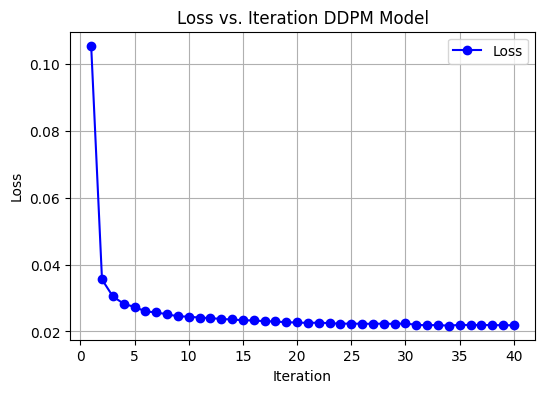

In [15]:
# Plotting model loss of DDPM training
iteration = list(range(1, len(model_loss) + 1))
plt.figure(figsize=(6, 4))
plt.plot(iteration, model_loss, marker='o', color='b', label='Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss vs. Iteration DDPM Model')
plt.legend()
plt.grid(True)
plt.show()

# Draw inference

In [21]:
def sample(model, scheduler, train_config, model_config, diffusion_config):
    """
    Sample stepwise by going backward one timestep at a time.
    We save the x0 predictions
    """
    sample_shape = (train_config['num_samples'], model_config['im_channels'], model_config['im_size'], model_config['im_size'])
    xt = torch.randn(sample_shape).to(device)

    # Starting backward from noisy image
    for i in tqdm(reversed(range(diffusion_config['num_timesteps'])), desc="Sampling Timesteps"):
        # Get prediction of noise
        noise_pred = model(xt, torch.as_tensor(i).unsqueeze(0).to(device))

        # Use scheduler to get x0 and xt-1
        xt, x0_pred = scheduler.sample_prev_timestep(xt, noise_pred, torch.as_tensor(i).to(device))

        # Save x0
        ims = torch.clamp(xt, -1., 1.).detach().cpu()
        ims = (ims + 1) / 2
        grid = make_grid(ims, nrow=train_config['num_grid_rows'])
        img = torchvision.transforms.ToPILImage()(grid)


        # Create directories if they don't exist
        samples_dir = os.path.join(train_config['task_name'], 'samples')
        os.makedirs(samples_dir, exist_ok=True)

        img.save(os.path.join(samples_dir, f'x0_{i}.png'))
        img.close()

def inference(config_path = 'config/mnist.yaml'):
    # Read the config file
    with open(config_path, 'r') as file:
        try:
            config = yaml.safe_load(file)
        except yaml.YAMLError as exc:
            print(f"Error reading the config file: {exc}")
    print(config)

    diffusion_config = config['diffusion_params']
    model_config = config['model_params']
    train_config = config['train_params']

    # Load model with checkpoint
    model = Unet(model_config).to(device)
    assert os.path.exists(os.path.join(train_config['task_name'],
                                       train_config['ddpm_ckpt_name'])), "Train DDPM first"
    model.load_state_dict(torch.load(os.path.join(train_config['task_name'],
                                                  train_config['ddpm_ckpt_name']), map_location=device))
    model.eval()

    # Create the noise scheduler
    scheduler = LinearNoiseScheduler(num_timesteps=diffusion_config['num_timesteps'],
                                     beta_start=diffusion_config['beta_start'],
                                     beta_end=diffusion_config['beta_end'])
    with torch.no_grad():
        sample(model, scheduler, train_config, model_config, diffusion_config)

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print('Using mps')

inference(config_path = 'config/mnist.yaml')

{'dataset_params': {'im_path': 'data/mnist/train/images', 'im_test_path': 'data/mnist/test/images', 'canny_im_size': 28}, 'diffusion_params': {'num_timesteps': 1000, 'beta_start': 0.0001, 'beta_end': 0.02}, 'model_params': {'im_channels': 1, 'im_size': 28, 'hint_channels': 3, 'down_channels': [32, 64, 128, 256], 'mid_channels': [256, 256, 128], 'down_sample': [True, True, False], 'time_emb_dim': 128, 'num_down_layers': 2, 'num_mid_layers': 2, 'num_up_layers': 2, 'num_heads': 4}, 'train_params': {'task_name': 'mnist', 'batch_size': 64, 'num_epochs': 40, 'controlnet_epochs': 1, 'num_samples': 25, 'num_grid_rows': 5, 'ddpm_lr': 0.0001, 'controlnet_lr': 0.0001, 'ddpm_ckpt_name': 'ddpm_ckpt.pth', 'controlnet_ckpt_name': 'ddpm_controlnet_ckpt.pth'}}


<ipython-input-21-34f9cfd171f6>:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(train_config['task_name'],
Sampling Timesteps

# Plot Inference

In [27]:
# Move to project directory
%cd /content/drive/MyDrive/ControlNet-ECE570/


def plot_samples(samples_dir, interval, max_samples, config_path='config/mnist.yaml'):
    """
    Plot MNIST images from the specified directory with annotations.

    Parameters:
    samples_dir (str): Directory containing the sample images.
    interval (int): The interval at which to plot the images (e.g., every 200 samples).
    max_samples (int): The maximum number of samples to plot.
    """
    # Load num_timesteps from config file
    with open(config_path, 'r') as file:
        try:
            config = yaml.safe_load(file)
        except yaml.YAMLError as exc:
            print(f"Error reading the config file: {exc}")
            return  # Exit if config loading fails

    plt.figure(figsize=(20, 15))  # Set the figure size
    count = 0  # Initialize a counter for plotting
    for i in range(0, config['diffusion_params']['num_timesteps'], interval):
        img_path = os.path.join(samples_dir, f'x0_{i}.png')  # Create the path for the image
        if os.path.exists(img_path):
            img = Image.open(img_path)
            plt.subplot(5, 5, count + 1)
            plt.imshow(img)  # Display the image in grayscale
            plt.axis('off')  # Hide the axes

            # Add annotation for the sample number
            plt.text(0.5, -0.1, f'Iteration: {i}', fontsize=12, ha='center', transform=plt.gca().transAxes)
            count += 1
        else:
            print(f"Image {img_path} does not exist.")

    plt.suptitle(f'Trained MNIST Samples with diffusion model Every {interval} Steps', fontsize=16)
    plt.tight_layout(pad=1)
    plt.subplots_adjust(top=0.95)
    plt.show()


/content/drive/MyDrive/ControlNet-ECE570


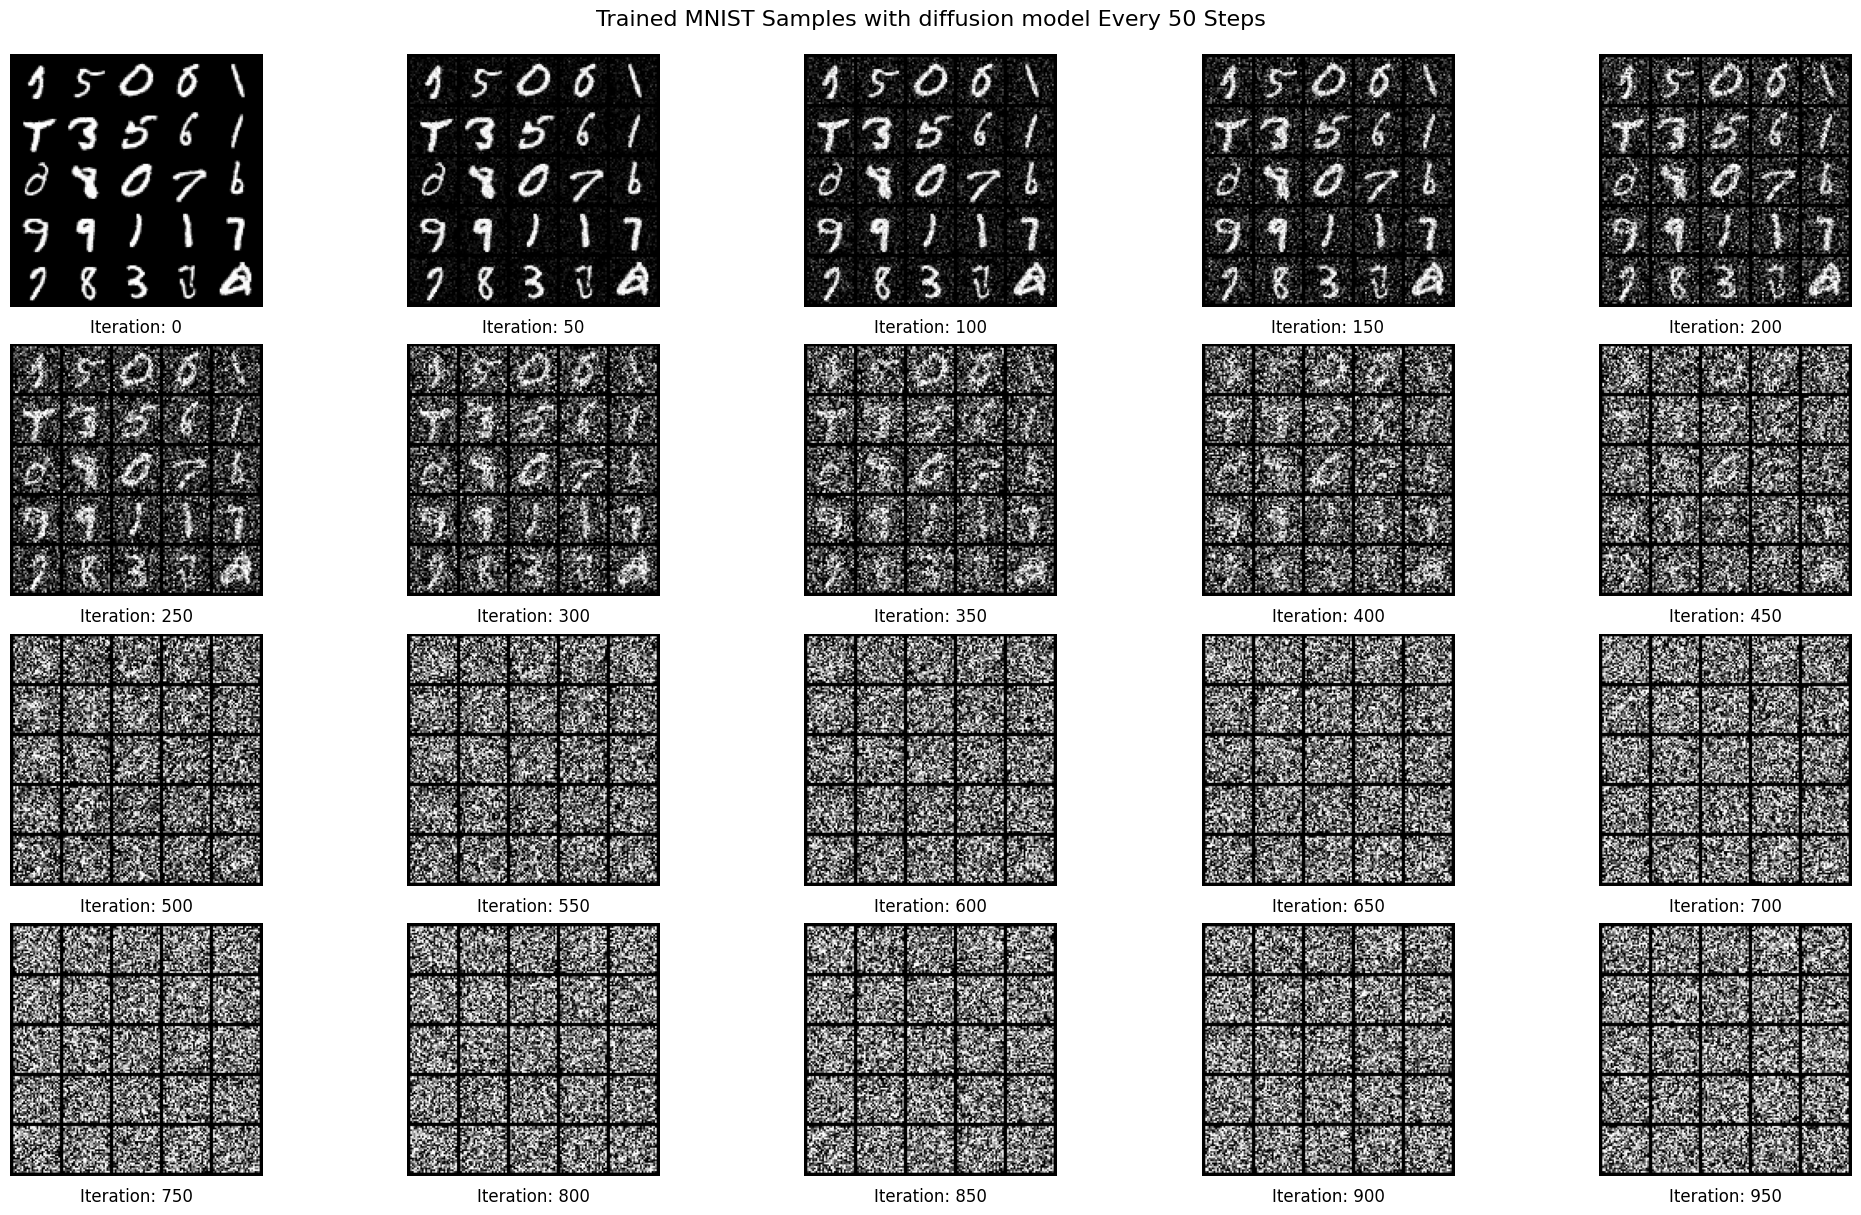

<Figure size 640x480 with 0 Axes>

In [30]:
samples_directory = '/content/drive/MyDrive/ControlNet-ECE570/mnist/samples'
interval = 50
max_samples = 100
plot_samples(samples_directory, interval, max_samples)
plt.savefig("generated_ddpm.png", format='png', dpi=300, bbox_inches='tight')

# Diffusion Model with ControlNet

The ControlNet class extends a pre-trained U-Net model by adding a control network that leverages hint inputs for diffusion model training. It includes specialized zeroed-out convolutional layers to modulate the U-Net's encoder and mid-block outputs, allowing fine control over the diffusion process. The model can selectively freeze or unlock layers for training, optimizing specific parameters based on configuration.

In [32]:
# Function to zero out parameters of a module (freeze it in place)
def make_zero_module(module):
    for p in module.parameters():
        p.detach().zero_()  # Detach gradients and set all weights to zero
    return module

# ControlNet Class Definition
class ControlNet(nn.Module):
    """
    ControlNet Module for Diffusion Model Training
    Args:
      model_config
      model_locked (boolean)": If True, model layers are locked.
      model_ckpt (str): Path to the model checkpoint.
      device (str): Device (GPU if any) to run the model on.
    Returns:
      None
    """
    def __init__(self, model_config,
                 model_locked=True,
                 model_ckpt=None,
                 device=None):
        super().__init__()

        # Initialize a trained U-Net model
        self.model_locked = model_locked  # Store if model layers are locked
        self.trained_unet = Unet(model_config)

        # Load weights into the trained U-Net model if checkpoint and device are provided
        if model_ckpt is not None and device is not None:
            print('Loading Trained Diffusion Model')
            self.trained_unet.load_state_dict(torch.load(model_ckpt,
                                                         map_location=device), strict=True)

        # Create a ControlNet copy of the trained U-Net model
        # with decoder layers removed by setting use_up to False
        self.control_copy_unet = Unet(model_config, use_up=False)

        # Load the same weights into the ControlNet copy
        if model_ckpt is not None and device is not None:
            print('Loading Control Diffusion Model')
            self.control_copy_unet.load_state_dict(torch.load(model_ckpt,
                                                              map_location=device), strict=False)

        # Define the Hint Block, which consists of several convolutional layers
        # and a zeroed-out convolution at the end
        self.control_copy_unet_hint_block = nn.Sequential(
            nn.Conv2d(model_config['hint_channels'],
                      64,
                      kernel_size=3,
                      padding=(1, 1)),
            nn.SiLU(),
            nn.Conv2d(64,
                      128,
                      kernel_size=3,
                      padding=(1, 1)),
            nn.SiLU(),
            nn.Conv2d(128,
                      self.trained_unet.down_channels[0],
                      kernel_size=3,
                      padding=(1, 1)),
            nn.SiLU(),
            make_zero_module(nn.Conv2d(self.trained_unet.down_channels[0],
                                       self.trained_unet.down_channels[0],
                                       kernel_size=1, padding = 0))
        )

        # Zero Convolution Modules for the encoder (down blocks)
        self.control_copy_unet_down_zero_convs = nn.ModuleList([
            make_zero_module(nn.Conv2d(self.trained_unet.down_channels[i],
                                       self.trained_unet.down_channels[i],
                                       kernel_size=1,
                                       padding=0))
            for i in range(len(self.trained_unet.down_channels)-1)
        ])

        # Zero Convolution Modules for the mid blocks
        self.control_copy_unet_mid_zero_convs = nn.ModuleList([
            make_zero_module(nn.Conv2d(self.trained_unet.mid_channels[i],
                                       self.trained_unet.mid_channels[i],
                                       kernel_size=1,
                                       padding=0))
            for i in range(1, len(self.trained_unet.mid_channels))
        ])

    # Function to retrieve parameters for optimization
    def get_params(self):
        params = list(self.control_copy_unet.parameters())

        params += list(self.control_copy_unet_hint_block.parameters())
        params += list(self.control_copy_unet_down_zero_convs.parameters())
        params += list(self.control_copy_unet_mid_zero_convs.parameters())

        if not self.model_locked:
            params += list(self.trained_unet.ups.parameters())
            params += list(self.trained_unet.norm_out.parameters())
            params += list(self.trained_unet.conv_out.parameters())
        return params  # Return the collected parameters

    # Forward pass through the ControlNet model
    def forward(self, x, t, hint):
        trained_unet_t_emb = get_time_embedding(torch.as_tensor(t).long(),
                                                self.trained_unet.t_emb_dim)
        trained_unet_t_emb = self.trained_unet.t_proj(trained_unet_t_emb)

        # Collect outputs of downblocks from the trained U-Net
        trained_unet_down_outs = []
        with torch.no_grad():  # Freeze trained U-Net
            train_unet_out = self.trained_unet.conv_in(x)
            for down in self.trained_unet.downs:
                trained_unet_down_outs.append(train_unet_out)
                train_unet_out = down(train_unet_out, trained_unet_t_emb)

        # Process ControlNet U-Net with time embedding and hint block
        control_copy_unet_t_emb = get_time_embedding(torch.as_tensor(t).long(),
                                                     self.control_copy_unet.t_emb_dim)
        control_copy_unet_t_emb = self.control_copy_unet.t_proj(control_copy_unet_t_emb)

        # Pass hint input through the hint block
        control_copy_unet_hint_out = self.control_copy_unet_hint_block(hint)

        # Pass input through the initial conv layer of ControlNet U-Net
        control_copy_unet_out = self.control_copy_unet.conv_in(x)
        control_copy_unet_out += control_copy_unet_hint_out

        # Collect downblock outputs for ControlNet
        control_copy_unet_down_outs = []
        for idx, down in enumerate(self.control_copy_unet.downs):
            # Zero conv output appended before down layer
            control_copy_unet_down_outs.append(
                self.control_copy_unet_down_zero_convs[idx](control_copy_unet_out)
            )
            control_copy_unet_out = down(control_copy_unet_out, control_copy_unet_t_emb)

        # Pass through the midblocks of ControlNet and trained U-Net
        for idx in range(len(self.control_copy_unet.mids)):
            control_copy_unet_out = self.control_copy_unet.mids[idx](
                control_copy_unet_out,
                control_copy_unet_t_emb
            )

            train_unet_out = self.trained_unet.mids[idx](train_unet_out, trained_unet_t_emb)

            # Combine ControlNet and trained U-Net mid outputs through zero convs
            train_unet_out += self.control_copy_unet_mid_zero_convs[idx](control_copy_unet_out)

        # Process through upblocks of the trained U-Net model
        for up in self.trained_unet.ups:
            # Pop downblock outputs and combine them
            trained_unet_down_out = trained_unet_down_outs.pop()
            control_copy_unet_down_out = control_copy_unet_down_outs.pop()
            train_unet_out = up(train_unet_out,
                                control_copy_unet_down_out + trained_unet_down_out,
                                trained_unet_t_emb)

        # Final output layer processing
        train_unet_out = self.trained_unet.norm_out(train_unet_out)
        train_unet_out = nn.SiLU()(train_unet_out)
        train_unet_out = self.trained_unet.conv_out(train_unet_out)
        return train_unet_out

# Train DDPM-ControlNet

In [34]:
# reduced_dataset_cnet = 1000
import time
# Define the main training function
def train(config_path='config/mnist.yaml', device='mps', training_small_dataset=False):

    start_time = time.time()  # Capture the start time
    # Load the configuration file
    with open(config_path, 'r') as file:
        try:
            config = yaml.safe_load(file)
        except yaml.YAMLError as exc:
            print(f"Error reading the config file: {exc}")
    print(config)  # Display the loaded configuration

    # Extract configurations for different components
    diffusion_config = config['diffusion_params']
    dataset_config = config['dataset_params']
    model_config = config['model_params']
    train_config = config['train_params']

    # Initialize the noise scheduler
    scheduler = LinearNoiseScheduler(num_timesteps=diffusion_config['num_timesteps'],
                                     beta_start=diffusion_config['beta_start'],
                                     beta_end=diffusion_config['beta_end'])

    # Set up the dataset and data loader
    mnist = MnistDataset('train',  # Specify training data
                         im_path=dataset_config['im_path'],
                         return_hints=True)
    print(f'MNIST Dataset Size: {len(mnist)}')

    # If testing with a larger dataset, use a subset of it initially,
    if training_small_dataset:
        mnist = torch.utils.data.Subset(mnist, list(range(reduced_dataset_cnet)))
        print(f'Reduced MNIST Dataset Size: {len(mnist)}')

    mnist_loader = DataLoader(mnist, batch_size=train_config['batch_size'], shuffle=True)

    # Initialize the model and load a checkpoint if available
    model = ControlNet(model_config,
                       model_locked=True,  # Use model in locked mode
                       model_ckpt=os.path.join(train_config['task_name'],
                                               train_config['ddpm_ckpt_name']),
                       device=device).to(device)

    model.train()  # Set model to training mode

    # Create directory to save training outputs if it doesn't exist
    if not os.path.exists(train_config['task_name']):
        os.mkdir(train_config['task_name'])

    # Load a previous checkpoint if available
    if os.path.exists(os.path.join(train_config['task_name'],
                                   train_config['controlnet_ckpt_name'])):
        print('Loading checkpoint as one was found')
        model.load_state_dict(torch.load(os.path.join(train_config['task_name'],
                                                      train_config['controlnet_ckpt_name']),
                                         map_location=device))

    # Set up training parameters
    num_epochs = train_config['controlnet_epochs']
    optimizer = Adam(model.get_params(), lr=train_config['controlnet_lr'])
    criterion = torch.nn.MSELoss()


    epoch_losses_CNet = []
    # Run the training loop

    for epoch_idx in range(num_epochs):
        losses = []
        for im, hint in tqdm(mnist_loader):
            optimizer.zero_grad()

            # Move data to the correct device and ensure it's in float format
            im = im.float().to(device)
            hint = hint.float().to(device)

            # Generate random noise and sample timesteps
            noise = torch.randn_like(im).to(device)  # Create random noise
            t = torch.randint(0, diffusion_config['num_timesteps'], (im.shape[0],)).to(device)

            # Add noise to images based on the timestep
            noisy_im = scheduler.add_noise(im, noise, t)

            # Predict noise using model, then compute and backpropagate the loss
            noise_predicton = model(noisy_im, t, hint)
            loss = criterion(noise_predicton, noise)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()

        avg_epoch_loss = np.mean(losses)
        epoch_losses_CNet.append(avg_epoch_loss)


        # # print('Finished epoch:{} | Loss : {:.4f}'.format(epoch_idx + 1, np.mean(losses),))
        # print(f'Finished epoch: {epoch_idx + 1} | Average Loss: {avg_epoch_loss:.4f}')
        print('***'*40)
        print(f'Finished epoch: {epoch_idx + 1} | Average Loss: {avg_epoch_loss:.4f}')
        print('***'*40)

        # Save model state after each epoch
        torch.save(model.state_dict(), os.path.join(train_config['task_name'],
                                                    train_config['controlnet_ckpt_name']))
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f'Training time: {elapsed_time:.2f} seconds')
    print(f'Done training!')
    return epoch_losses_CNet

In [35]:
# Move to project directory
%cd /content/drive/MyDrive/ControlNet-ECE570

# Main execution
mnist_train_config = 'config/mnist.yaml'

# Set the device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print('Using MPS')


print(f'Start training!')

# Call the function to train on the dataset
model_loss_CNet = train(mnist_train_config, device, training_small_dataset= False) # Set False for full dataset

/content/drive/MyDrive/ControlNet-ECE570
Start training!
{'dataset_params': {'im_path': 'data/mnist/train/images', 'im_test_path': 'data/mnist/test/images', 'canny_im_size': 28}, 'diffusion_params': {'num_timesteps': 1000, 'beta_start': 0.0001, 'beta_end': 0.02}, 'model_params': {'im_channels': 1, 'im_size': 28, 'hint_channels': 3, 'down_channels': [32, 64, 128, 256], 'mid_channels': [256, 256, 128], 'down_sample': [True, True, False], 'time_emb_dim': 128, 'num_down_layers': 2, 'num_mid_layers': 2, 'num_up_layers': 2, 'num_heads': 4}, 'train_params': {'task_name': 'mnist', 'batch_size': 64, 'num_epochs': 40, 'controlnet_epochs': 1, 'num_samples': 25, 'num_grid_rows': 5, 'ddpm_lr': 0.0001, 'controlnet_lr': 0.0001, 'ddpm_ckpt_name': 'ddpm_ckpt.pth', 'controlnet_ckpt_name': 'ddpm_controlnet_ckpt.pth'}}


100%|██████████| 10/10 [00:01<00:00,  9.67it/s]
<ipython-input-32-a3bd0bedcae8>:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.trained_unet.load_state_dict(torch.loa

Found 60000 images for split "train"
MNIST Dataset Size: 60000
Loading Trained Diffusion Model


<ipython-input-32-a3bd0bedcae8>:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.control_copy_unet.load_state_dict(torch.load(model_ckpt,


Loading Control Diffusion Model


100%|██████████| 938/938 [08:07<00:00,  1.93it/s]


************************************************************************************************************************
Finished epoch: 1 | Average Loss: 0.0171
************************************************************************************************************************
Training time: 489.00 seconds
Done training!


# Sampling and Inference

In [36]:
def generate_samples(model, scheduler, train_cfg, model_cfg, diff_cfg, dataset):
    """
    Generate samples by iteratively going backwards through time steps.
    Stores intermediate x_0 predictions.
    """
    # Initialize with random noise
    x_t = torch.randn((train_cfg['num_samples'],
                       model_cfg['im_channels'],
                       model_cfg['im_size'],
                       model_cfg['im_size'])).to(device)

    # Randomly select hints from the dataset
    hints = torch.cat([dataset[random.randint(0, len(dataset) - 1)][1].unsqueeze(0).to(device)
                       for _ in range(train_cfg['num_samples'])], dim=0).to(device)

    # Save hint images
    hint_image_grid = make_grid(hints, nrow=train_cfg['num_grid_rows'])
    hint_image = torchvision.transforms.ToPILImage()(hint_image_grid)
    hint_image.save(os.path.join(train_cfg['task_name'], 'hint.png'))

    # Reverse diffusion process
    for t in tqdm(reversed(range(diff_cfg['num_timesteps']))):
        # Predict noise for current step
        noise_predicton = model(x_t, torch.tensor([t], device=device), hints)

        # Calculate x_0 and previous x_t with scheduler
        x_t, x0_pred = scheduler.sample_prev_timestep(x_t, noise_predicton, torch.as_tensor(t).to(device))

        # Save predicted x_0 images
        normalized_imgs = (torch.clamp(x_t, -1, 1) + 1) / 2
        sample_grid = make_grid(normalized_imgs.cpu(), nrow=train_cfg['num_grid_rows'])
        sample_image = torchvision.transforms.ToPILImage()(sample_grid)

        save_dir = os.path.join(train_cfg['task_name'], 'samples_controlnet')
        os.makedirs(save_dir, exist_ok=True)
        sample_image.save(os.path.join(save_dir, f'x0_{t}.png'))
        sample_image.close()


def run_inference(config_path ='config/mnist.yaml'):
    # Load configuration
    with open(config_path, 'r') as f:
        try:
            config = yaml.safe_load(f)
        except yaml.YAMLError as e:
            print("Error loading configuration file:", e)
            return

    # Extract configurations
    diffusion_config = config['diffusion_params']
    model_config = config['model_params']
    train_config = config['train_params']
    dataset_config = config['dataset_params']

    # Load dataset with hint annotations
    mnist_canny_dataset = MnistDataset('test', im_path=dataset_config['im_test_path'], return_hints=True)

    # Initialize model with ControlNet checkpoint
    model = ControlNet(model_config,
                       model_ckpt=os.path.join(train_config['task_name'],
                       train_config['ddpm_ckpt_name']),
                       device=device).to(device)

    # Ensure ControlNet checkpoint exists before loading
    controlnet_ckpt_path = os.path.join(train_config['task_name'], train_config['controlnet_ckpt_name'])

    assert os.path.exists(controlnet_ckpt_path), "ControlNet checkpoint not found. Train the model first."
    model.load_state_dict(torch.load(controlnet_ckpt_path, map_location=device))
    model.eval()
    print('ControlNet checkpoint loaded successfully.')

    # Set up noise scheduler
    scheduler = LinearNoiseScheduler(num_timesteps=diffusion_config['num_timesteps'],
                                     beta_start=diffusion_config['beta_start'],
                                     beta_end=diffusion_config['beta_end'])

    # Generate samples with no gradient computation
    with torch.no_grad():
        generate_samples(model, scheduler, train_config, model_config, diffusion_config, mnist_canny_dataset)

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print('Using mps')

%cd /content/drive/MyDrive/ControlNet-ECE570
run_inference(config_path ='config/mnist.yaml')

/content/drive/MyDrive/ControlNet-ECE570


100%|██████████| 10/10 [00:00<00:00, 82.44it/s]

Found 10000 images for split "test"



<ipython-input-32-a3bd0bedcae8>:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.trained_unet.load_state_dict(torch.load(model_ckpt,


Loading Trained Diffusion Model
Loading Control Diffusion Model


<ipython-input-32-a3bd0bedcae8>:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.control_copy_unet.load_state_dict(torch.load(model_ckpt,
<ipython-input-36-e514e35382e

ControlNet checkpoint loaded successfully.


1000it [00:50, 19.82it/s]


# Plot the inferences

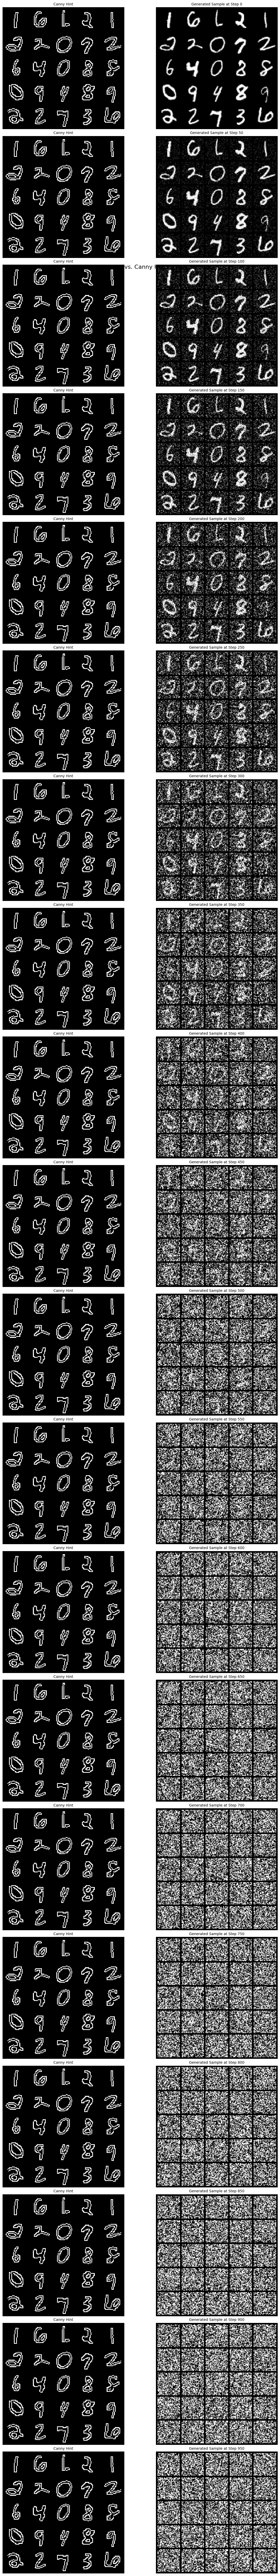

<Figure size 640x480 with 0 Axes>

In [47]:
def plot_generated_and_hint_samples(samples_dir, hint_img_path, interval, max_samples, config_path='config/mnist.yaml'):
    """
    Plot generated samples alongside their Canny hint images for comparison.

    Parameters:
    samples_dir (str): Directory containing the generated sample images.
    hint_img_path (str): Path to the Canny hint images file.
    interval (int): Interval at which to plot the generated images.
    max_samples (int): Maximum number of samples to plot.
    """
    # Load num_timesteps from config file
    with open(config_path, 'r') as file:
        try:
            config = yaml.safe_load(file)
        except yaml.YAMLError as exc:
            print(f"Error reading the config file: {exc}")
            return  # Exit if config loading fails

    num_timesteps = config['diffusion_params']['num_timesteps']
    plt.figure(figsize=(12, max_samples * 5))  # Set the figure size for a larger display

    # Load the hint images (assumes hints are saved in a single grid image)
    hint_img = Image.open(hint_img_path)

    count = 0  # Initialize counter for plotting
    for step in range(0, num_timesteps, interval):
        gen_img_path = os.path.join(samples_dir, f'x0_{step}.png')  # Path for each generated image
        if os.path.exists(gen_img_path):
            gen_img = Image.open(gen_img_path)

            # Plot the hint and generated images side by side
            plt.subplot(max_samples, 2, count * 2 + 1)
            plt.imshow(hint_img, cmap='gray')
            plt.axis('off')
            plt.title(f'Canny Hint', fontsize=10)

            plt.subplot(max_samples, 2, count * 2 + 2)
            plt.imshow(gen_img, cmap='gray')
            plt.axis('off')
            plt.title(f'Generated Sample at Step {step}', fontsize=10)

            count += 1
        else:
            print(f"Generated image {gen_img_path} does not exist.")


        if count >= max_samples:
            break

    plt.suptitle(f'Generated Samples vs. Canny Hints Every {interval} Steps', fontsize=16)
    plt.tight_layout(pad=0.5)
    plt.subplots_adjust(top=1)
    plt.show()


    plt.savefig("generated_vs_canny_comparison.png", format='png', dpi=300, bbox_inches='tight')

# Call the function
generated_samples_directory = '/content/drive/MyDrive/ControlNet-ECE570/mnist/samples_controlnet'
hint_image_path = '/content/drive/MyDrive/ControlNet-ECE570/mnist/hint.png'
interval = 50  # Interval
max_samples = 100  # Number of samples to compare
plot_generated_and_hint_samples(generated_samples_directory, hint_image_path, interval, max_samples)


In [40]:
def create_evolution_video(samples_dir, hint_img_path, num_timesteps, output_video_path, fps):
    """
    Create a video showing the evolution of generated samples alongside a Canny edge hint.

    Parameters:
    samples_dir (str): Directory containing the generated sample images.
    hint_img_path (str): Path to the Canny edge hint image.
    num_timesteps (int): Total number of timesteps in the diffusion process.
    output_video_path (str): Output path for the video file.
    fps (int): Frames per second for the video.
    """
    # Load the hint image
    hint_img = Image.open(hint_img_path).convert('L')
    hint_img_np = np.array(hint_img)

    # Get the dimensions
    sample_img_path = os.path.join(samples_dir, 'x0_0.png')
    sample_img = Image.open(sample_img_path).convert('L')
    sample_img_np = np.array(sample_img)

    # Combine hint and sample
    frame_height, frame_width = sample_img_np.shape[0], sample_img_np.shape[1] * 2
    video_writer = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))


    for t in reversed(range(num_timesteps)):
        sample_img_path = os.path.join(samples_dir, f'x0_{t}.png')
        if os.path.exists(sample_img_path):
            sample_img = Image.open(sample_img_path).convert('L')
            sample_img_np = np.array(sample_img)


            combined_frame = np.concatenate((hint_img_np, sample_img_np), axis=1)

            # Add timestep
            combined_frame_bgr = cv2.cvtColor(combined_frame, cv2.COLOR_GRAY2BGR)
            cv2.putText(combined_frame_bgr, f'Timestep: {t}', (10, 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)



            video_writer.write(combined_frame_bgr)
        else:
            print(f"Image {sample_img_path} does not exist.")

    video_writer.release()
    print(f"Video saved to {output_video_path}")

Make a cool video to end the project! :)


In [41]:
samples_directory = '/content/drive/MyDrive/ControlNet-ECE570/mnist/samples_controlnet'
hint_image_path = '/content/drive/MyDrive/ControlNet-ECE570/mnist/hint.png'
output_video_path = '/content/drive/MyDrive/ControlNet-ECE570/mnist/samples_controlnet/evolution_video.mp4'
fps = 20  # Frames per second for the video
num_timesteps = 1000
# Create the video
create_evolution_video(samples_directory, hint_image_path, num_timesteps, output_video_path, fps)

Video saved to /content/drive/MyDrive/ControlNet-ECE570/mnist/samples_controlnet/evolution_video.mp4


In [42]:
# Export requirements.txt
!pip freeze > requirements.txt